# EDA
#### En esta primera parte disponemos de tres archivos JSON que contienen datos proporcionados por la compañía Steam, sobre juegos y usuarios.
#### Nuestra labor será analizar aspectos como valores nulos, duplicados, faltantes, tipos de datos, aplicar interpretación del negocio, entre otros.
#### Esta fase es primorial en cuanto que nos da los criterios para decidir qué tipo de transformaciones hacer en el ETL para disponibilizar una API y entrenar un modelo de machine learning.

## 1- Análisis de los juegos de Steam

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import json
import ast
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Leemos el primer archivo
lista = []
with open("Data/output_steam_games.json", "r", encoding="utf-8") as file:
    for i in file.readlines():
        lista.append(json.loads(i))

df_1 = pd.DataFrame(lista)

In [3]:
# Instanciamos el DF original en un segundo DF
# Esto lo hago con el objetivo de tener un punto de reinicio sin necesidad de volver a leer el JSON
df_output_steam_games = pd.DataFrame(df_1)

In [4]:
# Generamos una muestra del DF para obtener contexto
df_output_steam_games

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120440,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
120441,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"


In [5]:
# Revisamos las dimensiones de nuestro DF
tamaño = df_output_steam_games.shape
print(f"Las dimensiones del Df 'df_output_steam_games' son {tamaño}")

Las dimensiones del Df 'df_output_steam_games' son (120445, 13)


In [6]:
# Revisamos el formato de las columnas
formatos = df_output_steam_games.dtypes
print(f"""Las columnas de nuestro DF tienen los siguientes formatos:
      
{formatos}""")

Las columnas de nuestro DF tienen los siguientes formatos:
      
publisher       object
genres          object
app_name        object
title           object
url             object
release_date    object
tags            object
reviews_url     object
specs           object
price           object
early_access    object
id              object
developer       object
dtype: object


#### El tipo de formato devuelto puede indicar que las columnas tienen distintos tipos de datos. En el ETL debemos cambiar los tipos de datos a los formatos adecuados.

#### Podemos emplear una función que nos será util para revisar la cantidad de nulos y su porcentaje por columnas.

In [7]:
def info_nulos(df, decimales=2):
    df_nulos = pd.DataFrame({
        "columna": df.columns,
        "Número de nulos": df.isnull().sum(),
        "Porcentaje de nulos": (df.isnull().sum() / df.shape[0]) * 100.0
    })
    df_nulos["Porcentaje de nulos"] = df_nulos["Porcentaje de nulos"].round(decimales).astype(str) + "%"
    return df_nulos

In [8]:
info_nulos(df_output_steam_games)

,columna,Número de nulos,Porcentaje de nulos
publisher,publisher,96362,80.0%
genres,genres,91593,76.05%
app_name,app_name,88312,73.32%
title,title,90360,75.02%
url,url,88310,73.32%
release_date,release_date,90377,75.04%
tags,tags,88473,73.46%
reviews_url,reviews_url,88312,73.32%
specs,specs,88980,73.88%
price,price,89687,74.46%


#### Exploramos los duplicados.

In [9]:
for columna in df_output_steam_games.columns:
    print(columna, df_output_steam_games[columna].duplicated().sum())

publisher 112205


genres 119561
app_name 88350
title 90390
url 88309
release_date 116862
tags 105049
reviews_url 88312
specs 115795
price 120282
early_access 120442
id 88312
developer 109452


#### La alta cantidad de duplicados por columnas puede deberse a que varios juegos compaprten datos como "publisher", "genres", "release_year", entre otros.

#### -------------------------------------------------------------------------------------------------
#### Aquí podemos aplicar interpretación del negocio a partir del dataframe disponible.

In [10]:
# Eliminamos registros nulos y duplicados para no sesgar el análisis multivariado
df_output_steam_games = df_output_steam_games.dropna(how="all")

# Tomamos como referencia la columna "id" porque obervamos que cada título tiene un id único
df_output_steam_games = df_output_steam_games.drop_duplicates(subset="id", keep="first", inplace=False)
df_output_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32133 entries, 88310 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24081 non-null  object
 1   genres        28850 non-null  object
 2   app_name      32131 non-null  object
 3   title         30083 non-null  object
 4   url           32133 non-null  object
 5   release_date  30066 non-null  object
 6   tags          31970 non-null  object
 7   reviews_url   32132 non-null  object
 8   specs         31463 non-null  object
 9   price         30756 non-null  object
 10  early_access  32133 non-null  object
 11  id            32132 non-null  object
 12  developer     28834 non-null  object
dtypes: object(13)
memory usage: 3.4+ MB


In [11]:
info_nulos(df_output_steam_games)

,columna,Número de nulos,Porcentaje de nulos
publisher,publisher,8052,25.06%
genres,genres,3283,10.22%
app_name,app_name,2,0.01%
title,title,2050,6.38%
url,url,0,0.0%
release_date,release_date,2067,6.43%
tags,tags,163,0.51%
reviews_url,reviews_url,1,0.0%
specs,specs,670,2.09%
price,price,1377,4.29%


#### 1- Desarrolladores con más presencia.

In [12]:
# Intancimos el DF sin nulos en la columna "developer"
df_devs = df_output_steam_games.dropna(subset=["developer"])

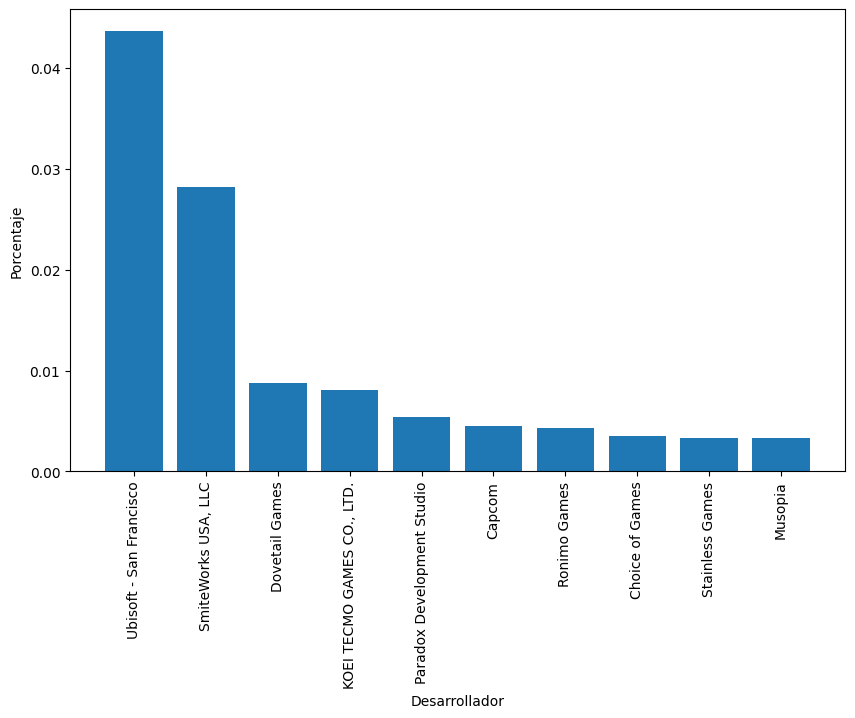

In [13]:
# Contar el número de juegos por desarrollador
developer_counts = df_devs["developer"].value_counts()

# Calcular el porcentaje de juegos por desarrollador
developer_percentages = developer_counts / len(df_devs)

# Ordenar los desarrolladores por porcentaje
developer_percentages = developer_percentages.sort_values(ascending=False)

# Graficar los 10 desarrolladores con más porcentaje
plt.figure(figsize=(10, 6))
plt.bar(developer_percentages.index[:10], developer_percentages[:10])
plt.xlabel("Desarrollador")
plt.ylabel("Porcentaje")
plt.xticks(developer_percentages.index[:10], rotation=90)
plt.show()

#### 2- Los años de lanzamiento son otras variables categóricas interesantes.

In [14]:
# Creamos columna con el año de lanzamiento
df_output_steam_games["release_year"] = df_output_steam_games["release_date"].str.extract(r"(\d{4})")

# Eliminamos columna innecesaria
df_output_steam_games.drop("release_date", axis=1, inplace=True)

# Mostramos información del DataFrame
df_output_steam_games["release_year"]

88310     2018
88311     2018
88312     2017
88313     2017
88314      NaN
          ... 
120440    2018
120441    2018
120442    2018
120443    2017
120444     NaN
Name: release_year, Length: 32133, dtype: object

In [15]:
df_años = df_output_steam_games.dropna(subset=["release_year"])
info_nulos(df_años)

,columna,Número de nulos,Porcentaje de nulos
publisher,publisher,5998,20.02%
genres,genres,1234,4.12%
app_name,app_name,1,0.0%
title,title,1,0.0%
url,url,0,0.0%
tags,tags,161,0.54%
reviews_url,reviews_url,0,0.0%
specs,specs,669,2.23%
price,price,1149,3.83%
early_access,early_access,0,0.0%


In [16]:
df_años["release_year"] = df_años["release_year"].astype(int)
df_años["release_year"].describe()

count    29965.000000
mean      2014.878859
std         19.157128
min       1970.000000
25%       2014.000000
50%       2016.000000
75%       2017.000000
max       5275.000000
Name: release_year, dtype: float64

#### 3- Información sobre los precios.

In [17]:
# Eliminamos nulos en una instancia para no sesgar los datos
df_precios = df_output_steam_games.dropna(subset=["price"])
df_precios["price"] = df_precios["price"].replace('', 0.0, regex=True)

In [18]:
df_precios["price"] = pd.to_numeric(df_precios["price"], errors='coerce').fillna(0.0)
df_precios["price"] = df_precios["price"].astype(float)

In [19]:
# Generamos información sobre las estadísticas de los precios
df_precios["price"].describe()

count    30756.000000
mean         8.864831
std         15.901175
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

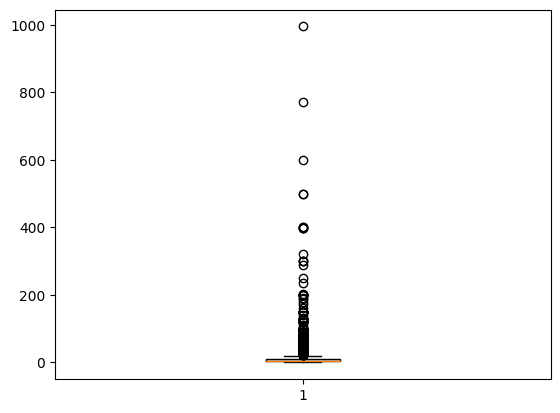

In [20]:
plt.boxplot(df_precios["price"])
plt.show()

In [21]:
mediana = df_precios["price"].median()
print(f" el valor de la mediana es: {mediana}")

 el valor de la mediana es: 4.99


#### Observamos mucha dispersión entre los precios más altos y bajos, la mediana y el valor con que podríamos rellenar nulos en el ETL si no se pueden eliminar sería de $4.99.

#### 4- Géneros.

In [22]:
df_output_steam_games = df_output_steam_games.dropna(subset=["genres"])
info_nulos(df_output_steam_games)

,columna,Número de nulos,Porcentaje de nulos
publisher,publisher,4897,16.97%
genres,genres,0,0.0%
app_name,app_name,1,0.0%
title,title,1,0.0%
url,url,0,0.0%
tags,tags,24,0.08%
reviews_url,reviews_url,0,0.0%
specs,specs,286,0.99%
price,price,1230,4.26%
early_access,early_access,0,0.0%


#### Los juegos pertenecen a distintos géneros, por tanto, esta columna tiene multiples valores por campo. Debemos aplicarle explode para comprender la estadística de los géneros.

In [23]:
df_output_steam_games = df_output_steam_games.explode("genres")
df_output_steam_games

,publisher,genres,app_name,title,url,tags,reviews_url,specs,price,early_access,id,developer,release_year
88310,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,2018
88310,Kotoshiro,Casual,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,2018
88310,Kotoshiro,Indie,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,2018
88310,Kotoshiro,Simulation,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,2018
88310,Kotoshiro,Strategy,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120442,Laush Studio,Indie,Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,2018
120442,Laush Studio,Racing,Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,2018
120442,Laush Studio,Simulation,Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,2018
120443,SIXNAILS,Casual,EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",2017


In [24]:
# Contar la cantidad de géneros únicos
num_genres = df_output_steam_games["genres"].nunique()

# Imprimir el resultado
print(f"La cantidad de géneros que componen el conjunto de juegos es: {num_genres}")

La cantidad de géneros que componen el conjunto de juegos es: 22


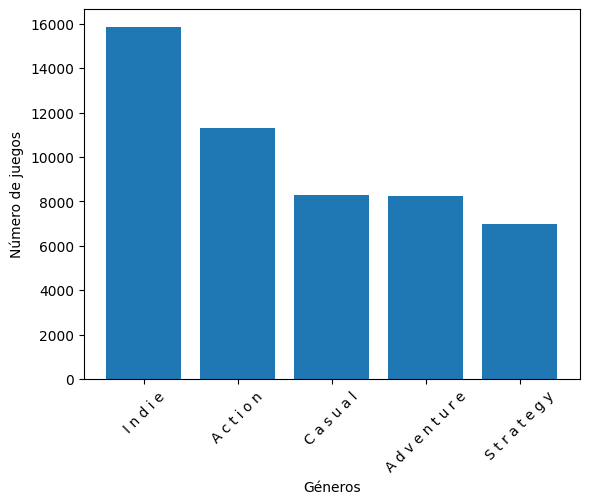

In [25]:
# Agrupar los datos por género
df_genres = df_output_steam_games.groupby("genres")

# Contar el número de juegos por género
df_genres = df_genres.size()

# Ordenar los géneros por número de juegos
df_genres = df_genres.sort_values(ascending=False)

# Seleccionar los 10 géneros con mayor número de juegos
df_genres = df_genres.head(5)

# Obtener las etiquetas para el gráfico
labels = []
for genre in df_genres.index:
    labels.append(" ".join(genre))

# Graficar el gráfico
plt.bar(df_genres.index, df_genres)
plt.xlabel("Géneros")
plt.ylabel("Número de juegos")
plt.xticks(df_genres.index, labels, rotation=45)
plt.show()

#### -------------------------------------------------------------------------------------------------
## 2- australian_users_items

In [26]:
# Leemos el archivo JSON y procedemos a crear un DF
australian_users_items = []
with open("Data/australian_users_items.json", "r", encoding="utf-8") as file:
    for i in file.readlines():
        australian_users_items.append(ast.literal_eval(i))

df_2 = pd.DataFrame(australian_users_items)

In [27]:
# Instanciamos el DF original en un segundo DF
# Esto lo hago con el objetivo de tener un punto de reinicio sin necesidad de volver a leer el JSON
df_australian_users_items = pd.DataFrame(df_2)
df_australian_users_items # Generamos una muestra del DF para obtener contexto

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
88305,76561198323066619,22,76561198323066619,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700687,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."


#### Nulos.

In [28]:
info_nulos(df_australian_users_items)

,columna,Número de nulos,Porcentaje de nulos
user_id,user_id,0,0.0%
items_count,items_count,0,0.0%
steam_id,steam_id,0,0.0%
user_url,user_url,0,0.0%
items,items,0,0.0%


In [29]:
df_australian_users_items["items"][0]

[{'item_id': '10',
  'item_name': 'Counter-Strike',
  'playtime_forever': 6,
  'playtime_2weeks': 0},
 {'item_id': '20',
  'item_name': 'Team Fortress Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '30',
  'item_name': 'Day of Defeat',
  'playtime_forever': 7,
  'playtime_2weeks': 0},
 {'item_id': '40',
  'item_name': 'Deathmatch Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '50',
  'item_name': 'Half-Life: Opposing Force',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '60',
  'item_name': 'Ricochet',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '70',
  'item_name': 'Half-Life',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '130',
  'item_name': 'Half-Life: Blue Shift',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '300',
  'item_name': 'Day of Defeat: Source',
  'playtime_forever': 4733,
  'playtime_2weeks': 0},
 {'item_id': '240',
  'item_name': 'Counter-Strike: S

#### Este dataset contiene registros por usuario, cada registro tiene en la columna "items" información sobre los juegos que el usuario ha bajado de Steam, el id de cada juego, nombre, tiempo de juego en las últimas dos semanas y tiempo total de juego.

In [30]:
tamaño = df_australian_users_items.shape
print(f"Las dimensiones del Df 'df_output_steam_games' son {tamaño}")

Las dimensiones del Df 'df_output_steam_games' son (88310, 5)


In [31]:
formatos = df_australian_users_items.dtypes
print(f"""Las columnas de nuestro DF tienen los siguientes formatos:
      
{formatos}""")

# En el ETL debemos cambiar los tipos de datos de las columnas a los formatos adecuados

Las columnas de nuestro DF tienen los siguientes formatos:
      
user_id        object
items_count     int64
steam_id       object
user_url       object
items          object
dtype: object


In [32]:
info_nulos(df_australian_users_items)

,columna,Número de nulos,Porcentaje de nulos
user_id,user_id,0,0.0%
items_count,items_count,0,0.0%
steam_id,steam_id,0,0.0%
user_url,user_url,0,0.0%
items,items,0,0.0%


In [33]:
# Tras revisar el contenido de la columna items, aplicamos el método "json_normalize()"
# Conservando las otras columnas del DF inicial
df_australian_users_items = pd.json_normalize(australian_users_items, record_path="items", meta=["steam_id", "items_count", "user_id", "user_url"])
df_australian_users_items

,item_id,item_name,playtime_forever,playtime_2weeks,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
...,...,...,...,...,...,...,...,...
5153204,346330,BrainBread 2,0,0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153205,373330,All Is Dust,0,0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153206,388490,One Way To Die: Steam Edition,3,3,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153207,521570,You Have 10 Seconds 2,4,4,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...


#### Duplicados serán examinados y eliminados tras la normalización de la columna "items".

#### Horas de juego.

In [34]:
df_australian_users_items["playtime_forever"] = df_australian_users_items["playtime_forever"].astype(int)
df_australian_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 8 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           object
 1   item_name         object
 2   playtime_forever  int32 
 3   playtime_2weeks   int64 
 4   steam_id          object
 5   items_count       object
 6   user_id           object
 7   user_url          object
dtypes: int32(1), int64(1), object(6)
memory usage: 294.9+ MB


In [35]:
df_playtime = df_australian_users_items[["user_id", "playtime_forever"]]
df_playtime

,user_id,playtime_forever
0,76561197970982479,6
1,76561197970982479,0
2,76561197970982479,7
3,76561197970982479,0
4,76561197970982479,0
...,...,...
5153204,76561198329548331,0
5153205,76561198329548331,0
5153206,76561198329548331,3
5153207,76561198329548331,4


In [36]:
# Suma de playtime_forever por user_id
suma_playtime_por_usuario = df_playtime.groupby('user_id')['playtime_forever'].sum().reset_index()
suma_playtime_por_usuario["playtime_forever"] = round(suma_playtime_por_usuario["playtime_forever"] / 60, 2)
suma_playtime_por_usuario

,user_id,playtime_forever
0,--000--,2350.45
1,--ace--,1173.03
2,--ionex--,801.40
3,-2SV-vuLB-Kg,904.15
4,-404PageNotFound-,3854.33
...,...,...
70907,zzonci,7.15
70908,zzoptimuszz,1373.62
70909,zzydrax,77.33
70910,zzyfo,1026.45


In [37]:
suma_playtime_por_usuario["playtime_forever"].describe()

count    70912.000000
mean      1200.873787
std       1511.569913
min          0.000000
25%        191.965000
50%        739.175000
75%       1698.670000
max      77673.220000
Name: playtime_forever, dtype: float64

#### La media de horas jugadas por ususario es de 1200 aproximadamente. No obestante, los valores máximos atípicos pueden deberse a prácticas de multicuenta.

In [38]:
df_users_items = pd.DataFrame(df_2)
df_users_items

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
88305,76561198323066619,22,76561198323066619,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700687,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."


In [39]:
df_users_items["items_count"] = df_users_items["items_count"].astype(int)

In [40]:
df_users_items["items_count"].describe()

count    88310.000000
mean        58.353629
std        122.312095
min          0.000000
25%          3.000000
50%         26.000000
75%         73.000000
max       7762.000000
Name: items_count, dtype: float64

#### Tenemos que la media de juegos por ususario es de 58.
#### Ahora podemos ver la distribución de dichas cantidades.

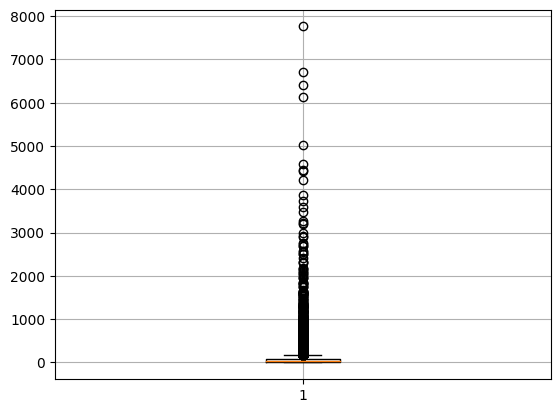

In [41]:
plt.boxplot(df_users_items["items_count"])
plt.grid()
plt.show()

#### Vemos que la mayoría de usuarios tienen menos de 1000 juegos.

#### -------------------------------------------------------------------------------------------------
## 3- australian_user_reviews

In [42]:
# Hacemos la lectura del JSON
lista = []
with open("Data/australian_user_reviews.json", "r", encoding="utf-8") as file:
    for i in file:
        lista.append(ast.literal_eval(i))

df_3 = pd.DataFrame(lista)

In [43]:
# Instanciamos el DF en otro para tener punto de recarga sin necesidad de volver a leer el JSON
df_australian_user_reviews = pd.DataFrame(df_3)
df_australian_user_reviews # Generamos una muestra

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."
...,...,...,...
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,"[{'funny': '', 'posted': 'Posted May 31.', 'la..."
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,"[{'funny': '', 'posted': 'Posted June 17.', 'l..."
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,"[{'funny': '1 person found this review funny',..."
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"[{'funny': '', 'posted': 'Posted July 21.', 'l..."


#### Dimensiones.

In [44]:
tamaño = df_australian_user_reviews.shape
print(f"Las dimensiones del Df 'df_output_steam_games' son {tamaño}")

Las dimensiones del Df 'df_output_steam_games' son (25799, 3)


#### Formato de los datos.

In [45]:
formatos = df_australian_user_reviews.dtypes
print(f"""Las columnas de nuestro DF tienen los siguientes formatos:
      
{formatos}""")

# En el ETL debemos cambiar los tipos de datos de las columnas a los formatos adecuados

Las columnas de nuestro DF tienen los siguientes formatos:
      
user_id     object
user_url    object
reviews     object
dtype: object


#### Nulos.

In [46]:
info_nulos(df_australian_user_reviews)

,columna,Número de nulos,Porcentaje de nulos
user_id,user_id,0,0.0%
user_url,user_url,0,0.0%
reviews,reviews,0,0.0%


#### Vemos que la columna "review" tiene datos anidados.

In [47]:
df_australian_user_reviews["reviews"][0]

[{'funny': '',
  'posted': 'Posted November 5, 2011.',
  'last_edited': '',
  'item_id': '1250',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'posted': 'Posted July 15, 2011.',
  'last_edited': '',
  'item_id': '22200',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'posted': 'Posted April 21, 2011.',
  'last_edited': '',
  'item_id': '43110',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]

In [48]:
# Tras revisar el contenido de la columna reviews, aplicamos el método "explode" para desanidarla
# Concatenamos el resultado con el DF original y borramos la columna "reviews" con datos anidados
df_australian_user_reviews = df_australian_user_reviews.explode("reviews").reset_index()
df_australian_user_reviews = pd.concat([df_australian_user_reviews.drop(columns="reviews"), df_australian_user_reviews["reviews"].apply(pd.Series)],axis=1)
df_australian_user_reviews # Generamos una muestra

,index,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,0
0,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,NaN
1,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,NaN
2,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,NaN
3,1,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,NaN
4,1,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
59328,25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...,NaN
59329,25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...,NaN
59330,25798,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...,NaN
59331,25798,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,,Posted July 20.,,730,No ratings yet,True,:D,NaN


#### Despues de desestructurar la última columna, suponemos que los Ids de los usuarios de este dataframe pueden coincidir con los del dataframe australian_user_item. Pasa lo mismo con los Ids de los juegos de este dataframe con los de outputs_steam_games.

#### Duplicados serán tratados en el ETL al desestructurar la columna "reviews".

#### Podemos graficar la proporción existente entre los juegos con buena y mala recomendación, de acuerdo a la columna con valores booleanos "recommend".

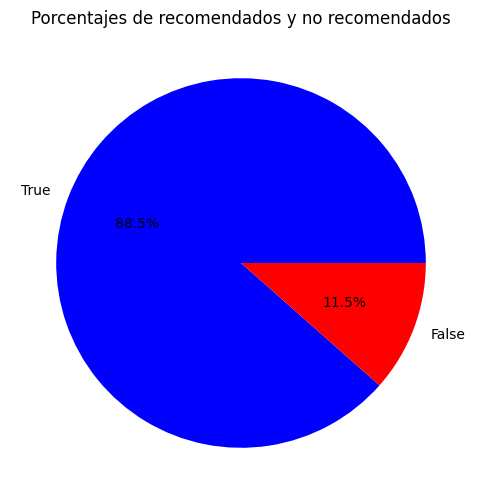

In [49]:
conteo_recomendaciones = df_australian_user_reviews["recommend"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(conteo_recomendaciones, labels=conteo_recomendaciones.index, autopct='%1.1f%%', colors=['blue', 'red'])
plt.title("Porcentajes de recomendados y no recomendados")
plt.show()

#### La desproporción entre estos porcentajes puede deberse a una dinámica particular en la plataforma Steam. A saber, que la mayoría de usuarios a los que no les gustan los juegos, tampoco los califican, mientras que aquellos que quedan satisfechos con el contenido de los juegos sí se toman el tiempo de hacer una recomendación.

#### Podemos obtener el top 10 de juegos más recomendados por su Id.

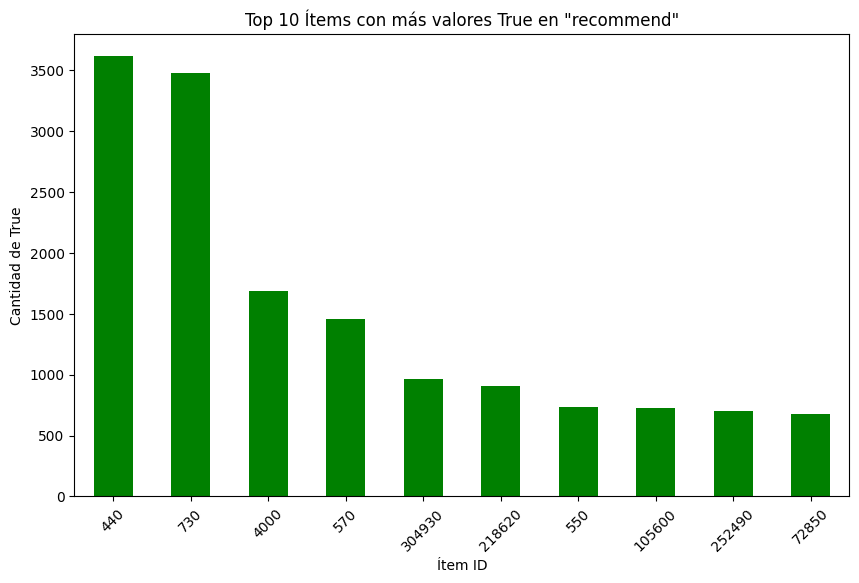

In [50]:
# Filtrar los valores True en la columna "recommend"
recomendaciones_true = df_australian_user_reviews[df_australian_user_reviews["recommend"] == True]

# Contar los True por "item_id"
conteo_true_por_item = recomendaciones_true["item_id"].value_counts()

# Obtener los 10 ítems con el mayor número de True en "recommend"
top_10_items = conteo_true_por_item.head(10)

# Crear un gráfico de barras con los 10 ítems con más valores True
plt.figure(figsize=(10, 6))
top_10_items.plot(kind="bar", color="green")
plt.title('Top 10 Ítems con más valores True en "recommend"')
plt.xlabel("Ítem ID")
plt.ylabel("Cantidad de True")
plt.xticks(rotation=45)
plt.show()

## Conclusiones
#### Como conclusiones generales de este análisis exploratorio de los datos tenemos que pueden llegar a existir interacciones entre tres dataframes, de tal modo, tendremos que encontrar la manera de relacionar dichos datos para que la estructura final de la información sea la propicia para satisfacer las consultas de nuestra API.
#### Por otra parte, podemos contruir un sistema de recomendación basado en el contenido de los juegos, a partir de técnicas de similitud del coseno.